In [1]:
import numpy as np
import NegotiationTools as negtools
import matplotlib.pyplot as plt
from skimage.draw import rectangle
import skimage as skim
import pandas as pd
import seaborn as sb
import Experiments as exp
import math

stats = negtools.StatisticsLogger()
nt = negtools.NegTools()

1
2
3
4
5
6
7
8
9
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 0 0 0 

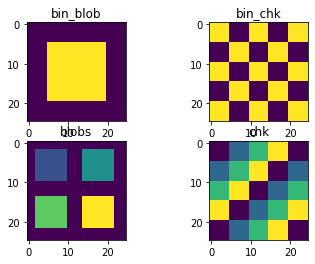

In [20]:
W = 25
H = 25
W2 = 5
H2 = 5
templates = dict()

templates['bin_blob'] = np.zeros((W, H), dtype=np.uint8)
templates['bin_blob'][tuple(rectangle(start=(5,5), extent=(15,15), shape=(W,H)))] = 1

templates['bin_chk'] = np.zeros((W, H), dtype=np.uint8)
is_one = True
for i in range(0,W,W2):
    for j in range(0,H,H2):
        if is_one is True:
            templates['bin_chk'][tuple(rectangle(start=(i,j), extent=(W2,H2), shape=(W,H)))] = 1
        is_one = not is_one
        
n_class = 4
blobs_w = 8
blobs_h = 8
w_off = 2
h_off = 2
blobs_val = 1

templates['blobs'] = np.zeros((W, H), dtype=np.uint8)
for i in range(0,W,blobs_w+2*w_off):
    for j in range(0,H,blobs_h+2*h_off):
        templates['blobs'][tuple(rectangle(start=(i+w_off,j+h_off), extent=(blobs_w,blobs_h), shape=(W,H)))] = blobs_val
        print(blobs_val)
        blobs_val = blobs_val+1

# FIXME:
templates['blobs'] = np.where(templates['blobs']>3, templates['blobs']-1, templates['blobs'])
        
        
W = 25
H = 25
CHK_W = 5
CHK_H = 5
val = 0
n_class = 4
templates['chk'] = np.zeros((W, H), dtype=np.uint8)
is_one = True
for i in range(0,W,CHK_W):
    for j in range(0,H,CHK_H):
        templates['chk'][tuple(rectangle(start=(i,j), extent=(CHK_W,CHK_H), shape=(W,H)))] = val + 1
        val = (val + 1 ) % n_class
templates['chk'] = templates['chk'] - 1
        
for i, (name, templ) in enumerate(templates.items()):
    plt.subplot(2, math.ceil(len(templates.items())/2), i+1)
    plt.imshow(templ)
    plt.title(name)
    
print(templates['blobs'])

In [3]:
def agent_binary_balanced(mu, std):

    mu_mat = [[mu, 1.-mu],
           [1.-mu, mu]]
    std_mat = np.ones_like(mu_mat)*std
    return (np.asarray(mu_mat),np.asarray(std_mat))

def agent_binary_unbalanced(mu_1, mu_2, std):
    
    mu_mat = [[mu_1, 1.-mu_1],
           [1.-mu_2, mu_2]]
    std_mat = np.ones_like(mu_mat)*std
    return (np.asarray(mu_mat),np.asarray(std_mat))


def agent_multiclass_expert(mu_star, mu, std, c_star, n_labels):
    '''
    :param mu_star - "competence" on expertise class
    :param mu - "competence" on non expertise classes
    :param std - standard deviation
    :param c_star - index of expertise class
    :param n_labels - number of labels
    '''
    gamma = 1 - mu - (1 - mu_star)/(n_labels-1)
    
    mat = list()
    for t in range(n_labels):
        row = list()
        for p in range(n_labels):
            if p == c_star and t == c_star:
                row.append(mu_star)
            elif t == c_star or p == c_star:
                row.append((1.-mu_star)/(n_labels - 1.))
            elif p == t:
                row.append(mu)
            else:
                row.append(gamma/(n_labels - 2.))
        mat.append(row)
    mu_mat = np.asarray(mat)
    std_mat = np.ones_like(mu_mat)*std
    return mu_mat, std_mat

def agent_multiclass_unbalanced(mu_star, mu, gamma, std, c_star, n_labels):
    '''
    :param mu_star - "competence" on expertise class
    :param mu - "competence" on non expertise classes
    :param std - standard deviation
    :param c_star - index of expertise class
    :param n_labels - number of labels
    '''
    
    mat = list()
    for t in range(n_labels):
        row = list()
        for p in range(n_labels):
            if p == c_star and t == c_star:
                row.append(mu_star)
            elif t == c_star:
                row.append((1.-mu_star)/(n_labels - 1.))
            elif p == c_star:
                row.append((1.-mu)*gamma)
            elif p == t:
                row.append(mu*gamma)
            else:
                row.append((1.-gamma)/(n_labels - 2.))
        mat.append(row)
    mu_mat = np.asarray(mat)
    std_mat = np.ones_like(mu_mat)*std
    return mu_mat, std_mat

def generate_predictions(gt_template, mu_matrix, std_matrix):
    prediction = list()
    # Iterating through the columns (predicted classes) of agent matrix, filling the corresponding ground_truth areas with predictions
    for pred_label in range(mu_matrix.shape[-1]):
        label_image = np.zeros_like(gt_template)
        for true_label in np.unique(gt_template):
            agent_labels = np.random.normal(loc=np.ones_like(gt_template)*mu_matrix[true_label, pred_label],scale=np.ones_like(gt_template)*std_matrix[true_label,pred_label])
            label_image = np.where(gt_template == true_label, agent_labels, label_image)
        prediction.append(label_image)
    prediction = np.stack(prediction, axis=-1)
    # Normalization
    prediction = np.clip(prediction, 0.0, 1.0)
    prediction = prediction / prediction.sum(axis=-1, keepdims=True) 
    return prediction

def generate_ground_truth(gt_template, n_labels):
    gt = list()
    for l in range(n_labels):
        gt_slice = np.where(gt_template==l, 1.0, 0.0)
        gt.append(gt_slice)
    return np.stack(gt, axis=-1)

## Experimental Design (Binary)

#### 1 balanced agent vs 2, 4, 8 unbalanced on C1

In [40]:
N_LABELS = 2
N_AGENTS = 3

mu = 0.75
std = 0.2
c_star = 0
template = templates['bin_blob']

# Generating agents
agents = [agent_binary_balanced(mu=mu, std=std) for a in range(N_AGENTS)]
# Generating ground truth and predictions
gt = generate_ground_truth(template, N_LABELS)
predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])

In [ ]:
template_name='bin_blob'
template = templates[template_name]
N_LABELS = 2
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 30
# Agents unbalanced on C1
log = pd.DataFrame()
for std in [0.01,0.05,0.1,0.2]:
    for unb_agents in [2, 4, 8]: 
        for mu_balanced in [.6, .75, .9]:
            for mu_1_unbalanced in [.6, .75, .9]:
                for mu_2_unbalanced in [0.4, 0.5]:
                    print("{} - 1 balanced agent (mu={}) vs {} unbalanced (mu1={}, mu2={}), noise std={}".format(template_name, mu_balanced, unb_agents, mu_1_unbalanced, mu_2_unbalanced, std) )
                    prediction_runs = list()
                    for i in range(SAMPLES):
                        balanced = agent_binary_balanced(mu=mu_balanced, std=std)
                        agents = [balanced] + [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents)]        
                        predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                        prediction_runs.append(predictions)
                    run_result = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    run_result['unbalanced_agents'] = unb_agents
                    run_result['mu_balanced'] = mu_balanced
                    run_result['mu_1_unbalanced'] = mu_1_unbalanced
                    run_result['mu_2_unbalanced'] = mu_2_unbalanced
                    run_result['std'] = std
                    log = log.append(run_result, ignore_index=True)

log.to_csv('results/{}_balanced_vs_unbalanced_c1.csv'.format(template_name))

In [ ]:
# Agents unbalanced on C2
log = pd.DataFrame()
for std in [0.01,0.05,0.1,0.2]:
    for unb_agents in [2, 4, 8]: 
        for mu_balanced in [.6, .75, .9]:
            for mu_1_unbalanced in [0.4, 0.5]:
                for mu_2_unbalanced in [.6, .75, .9]:
                    print("{} - 1 balanced agent (mu={}) vs {} unbalanced (mu1={}, mu2={}), noise std={}".format(template_name, mu_balanced, unb_agents, mu_1_unbalanced, mu_2_unbalanced, std) )
                    prediction_runs = list()
                    for i in range(SAMPLES):
                        balanced = agent_binary_balanced(mu=mu_balanced, std=std)
                        agents = [balanced] + [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents)]        
                        predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                        prediction_runs.append(predictions)
                    run_result = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    run_result['unbalanced_agents'] = unb_agents
                    run_result['mu_balanced'] = mu_balanced
                    run_result['mu_1_unbalanced'] = mu_1_unbalanced
                    run_result['mu_2_unbalanced'] = mu_2_unbalanced
                    run_result['std'] = std
                    log = log.append(run_result, ignore_index=True)

log.to_csv('results/{}_balanced_vs_unbalanced_c2.csv'.format(template_name))

In [46]:
# Half agents unbalanced on C1 and half on C2
log = pd.DataFrame()
for std in [0.01,0.05,0.1,0.2]:
    for unb_agents in [2, 4, 8]: 
        for mu_balanced in [.6, .75, .9]:
            for mu_1_unbalanced in [.6, .75, .9]:
                for mu_2_unbalanced in [0.4, 0.5]:
                    print("{} - 1 balanced agent (mu={}) vs {} unbalanced (mu1={}, mu2={}), noise std={}".format(template_name, mu_balanced, unb_agents, mu_1_unbalanced, mu_2_unbalanced, std) )
                    prediction_runs = list()
                    for i in range(SAMPLES):
                        balanced = agent_binary_balanced(mu=mu_balanced, std=std)
                        unbalanced_c1 = [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents//2)]
                        unbalanced_c2 = [agent_binary_unbalanced(mu_1=mu_2_unbalanced, mu_2=mu_1_unbalanced, std=std) for a in range(unb_agents//2)]
                        agents = [balanced] + unbalanced_c1 + unbalanced_c2
                        predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                        prediction_runs.append(predictions)
                    run_result = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    run_result['unbalanced_agents'] = unb_agents
                    run_result['mu_balanced'] = mu_balanced
                    run_result['mu_1_unbalanced'] = mu_1_unbalanced
                    run_result['mu_2_unbalanced'] = mu_2_unbalanced
                    run_result['std'] = std
                    log = log.append(run_result, ignore_index=True)

log.to_csv('results/{}_balanced_vs_unbalanced_half.csv'.format(template_name))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


0     0.4
1     0.4
2     0.4
3     0.4
4     0.4
5     0.4
6     0.4
7     0.4
8     0.4
9     0.4
10    0.4
11    0.5
12    0.5
13    0.5
14    0.5
15    0.5
16    0.5
17    0.5
18    0.5
19    0.5
20    0.5
21    0.5
Name: mu_2_unbalanced, dtype: float64

In [5]:
c_star = 0
mu = 0.6
template = templates['bin_blob']
N_LABELS = 2
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 30
log = pd.DataFrame()
for unb_agents in [2, 4, 8]:
    for std in [0.01,0.05,0.1,0.2]:
        for mu_balanced in [.6, .75, .9]:
            # Balanced Agent
            balanced = agent_binary_balanced(mu=mu, std=std)

            for mu_1_unbalanced in [.6, .75, .9]:
                for mu_2_unbalanced in [0.4, 0.5]:
                    # Running "SAMPLES" times
                    prediction_runs = list()

                    for i in range(SAMPLES):
                        agents = [balanced] + [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents)]        
                        predictions = np.stack([generate_predictions(template, agent_matrix) for agent_matrix in agents])
                        prediction_runs.append(predictions)

                    results = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    results['unbalanced_agents'] = unb_agents
                    results['mu_balanced'] = mu_balanced
                    results['mu_1_unbalanced'] = mu_1_unbalanced
                    results['mu_2_unbalanced'] = mu_2_unbalanced
                    results['std'] = std
                    log = log.append(results, ignore_index=True)
log.to_csv('results/binary_chk_balanced_vs_unbalanced_c1.csv'.format(std))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Con

KeyboardInterrupt: 

In [4]:
#Testing
c_star = 0
mu = 0.6
template_name = 'bin_chk'
template = templates[template_name]
N_LABELS = 2
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 1

# Agents unbalanced on C1
log = pd.DataFrame()
for std in [0.05]:
    for unb_agents in [2]: 
        for mu_balanced in [.8]:
            for mu_1_unbalanced in [.6]:
                for mu_2_unbalanced in [0.4]:
                    print("{} - 1 balanced agent (mu={}) vs {} unbalanced (mu1={}, mu2={}), noise std={}".format(template_name, mu_balanced, unb_agents, mu_1_unbalanced, mu_2_unbalanced, std) )
                    prediction_runs = list()
                    for i in range(SAMPLES):
                        balanced = agent_binary_balanced(mu=mu_balanced, std=std)
                        agents = [balanced] + [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents)]        
                        predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                        prediction_runs.append(predictions)
                    run_result, outputs = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES, return_outputs=True)
#                     run_result['unbalanced_agents'] = unb_agents
#                     run_result['mu_balanced'] = mu_balanced
#                     run_result['mu_1_unbalanced'] = mu_1_unbalanced
#                     run_result['mu_2_unbalanced'] = mu_2_unbalanced
#                     run_result['std'] = std
#                     log = log.append(run_result, ignore_index=True)

bin_chk - 1 balanced agent (mu=0.8) vs 2 unbalanced (mu1=0.6, mu2=0.4), noise std=0.05


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 5


In [5]:
run_result['non_consensus_px']

0     328.0
1     328.0
2     328.0
3     328.0
4     328.0
5     328.0
6     328.0
7     328.0
8     328.0
9     328.0
10    328.0
Name: non_consensus_px, dtype: float64

In [5]:
run_result

,Label 0_f1-score,Label 0_precision,Label 0_recall,Label 0_support,Label 1_f1-score,Label 1_precision,Label 1_recall,Label 1_support,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,non_consensus_px,method
0,0.018127,0.009146,1.0,3.0,0.000000,0.0,0.000000,325.0,0.009146,0.009063,0.004573,0.500000,328.0,0.000166,0.000084,0.009146,328.0,328.0,Majority Voting
1,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Maximum Proposal
2,0.250000,0.142857,1.0,3.0,0.971519,1.0,0.944615,325.0,0.945122,0.610759,0.571429,0.972308,328.0,0.964920,0.992160,0.945122,328.0,328.0,Mean Proposal
3,0.857143,0.750000,1.0,3.0,0.998459,1.0,0.996923,325.0,0.996951,0.927801,0.875000,0.998462,328.0,0.997167,0.997713,0.996951,328.0,328.0,Negotiation - 3x3 Conv Entropy
4,0.857143,0.750000,1.0,3.0,0.998459,1.0,0.996923,325.0,0.996951,0.927801,0.875000,0.998462,328.0,0.997167,0.997713,0.996951,328.0,328.0,Negotiation - 5x5 Conv Entropy
5,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Negotiation - Mean Entropy
6,0.600000,0.428571,1.0,3.0,0.993808,1.0,0.987692,325.0,0.987805,0.796904,0.714286,0.993846,328.0,0.990206,0.994774,0.987805,328.0,328.0,Negotiation - Pixelwise Entropy
7,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Weighted Mean - 3x3 Conv Entropy
8,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Weighted Mean - 5x5 Conv Entropy
9,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Weighted Mean - Mean Entropy


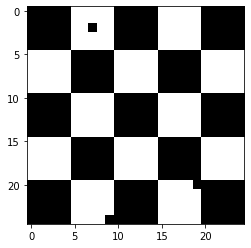

In [6]:
plt.imshow(nt.get_consensus(prediction_runs[0]), vmin=0, vmax=1, cmap='Greys_r')


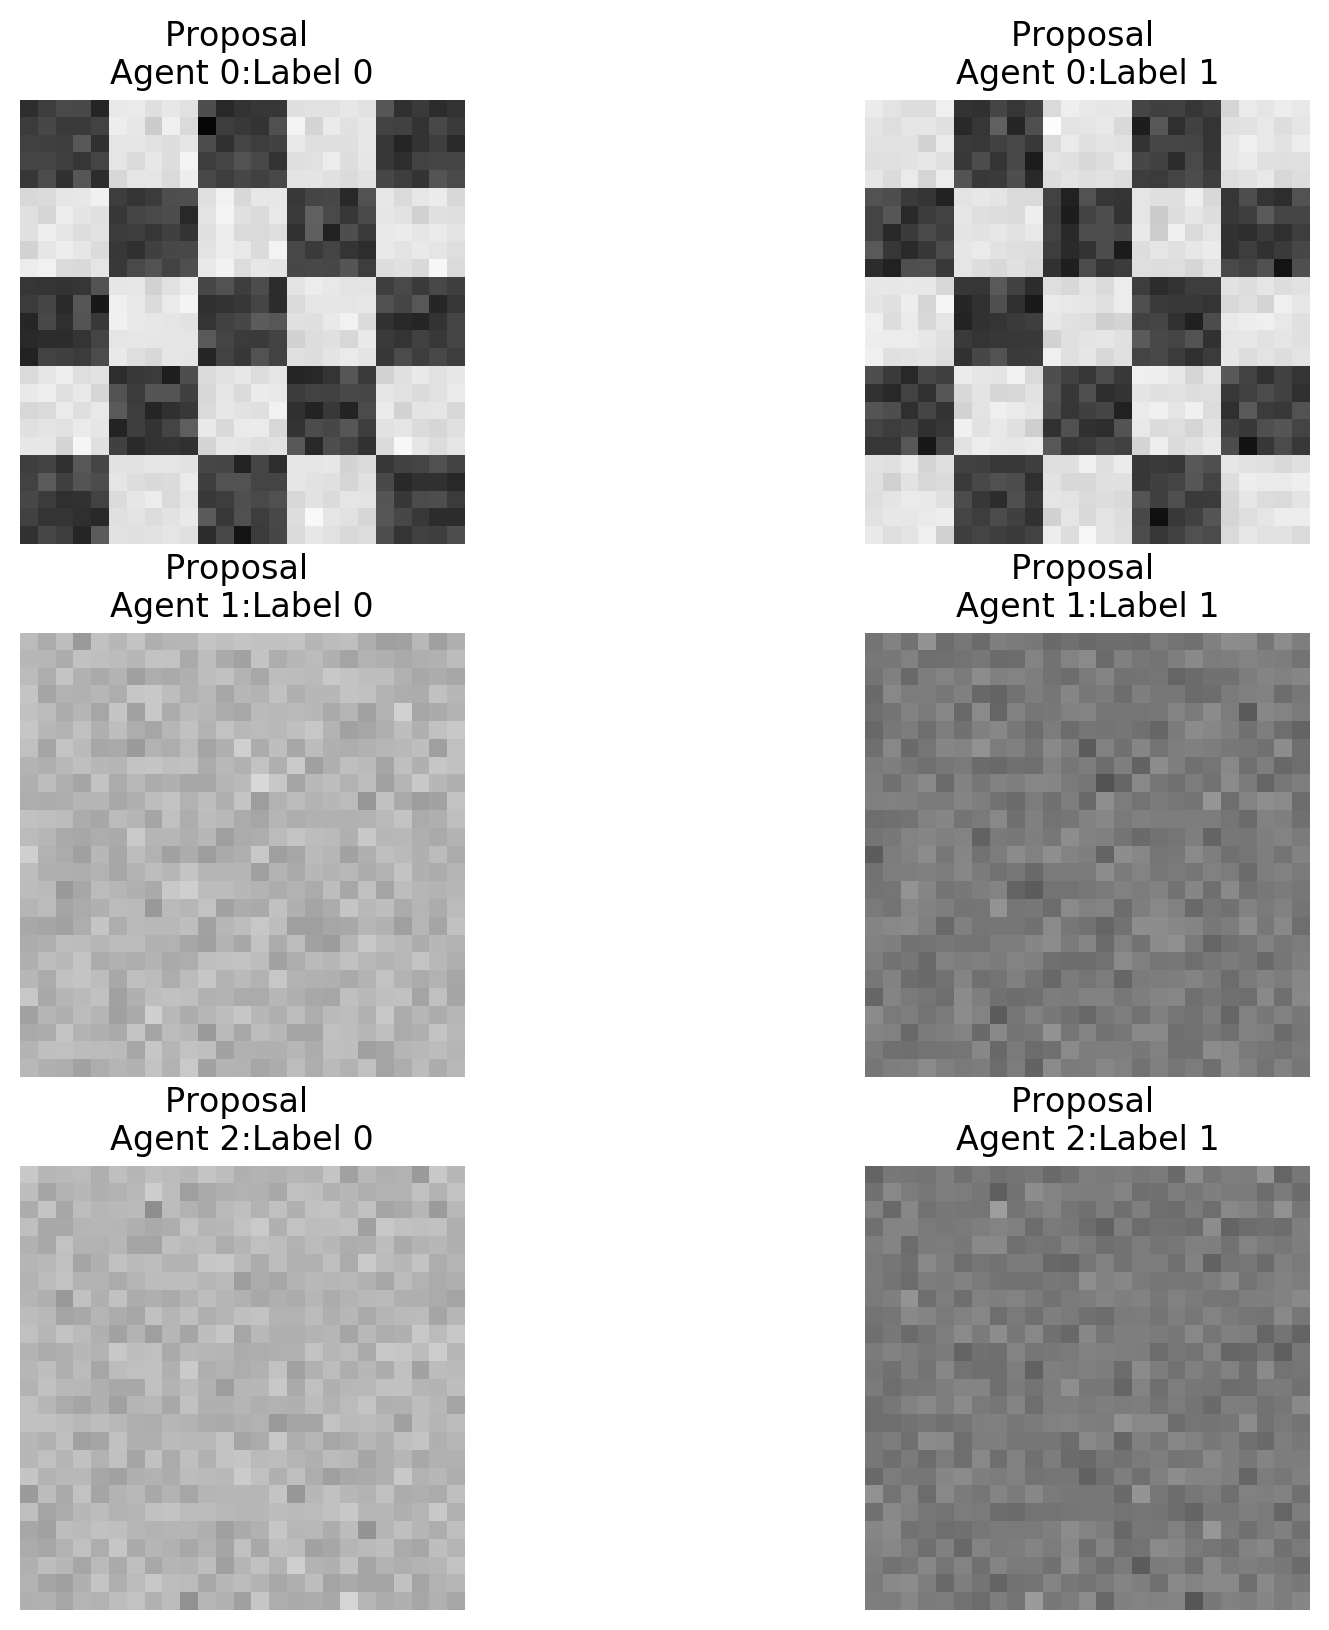

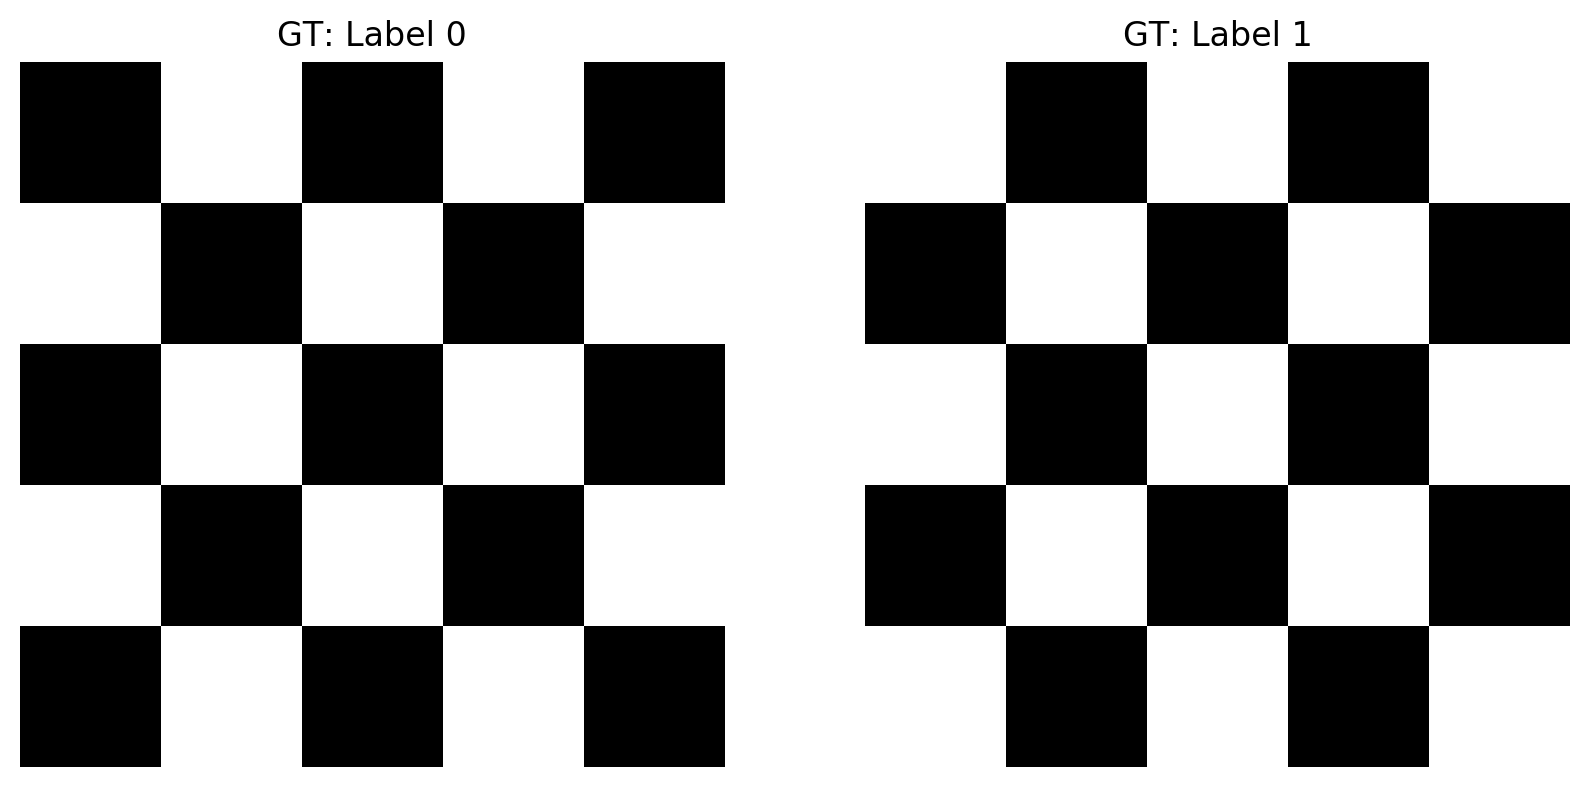

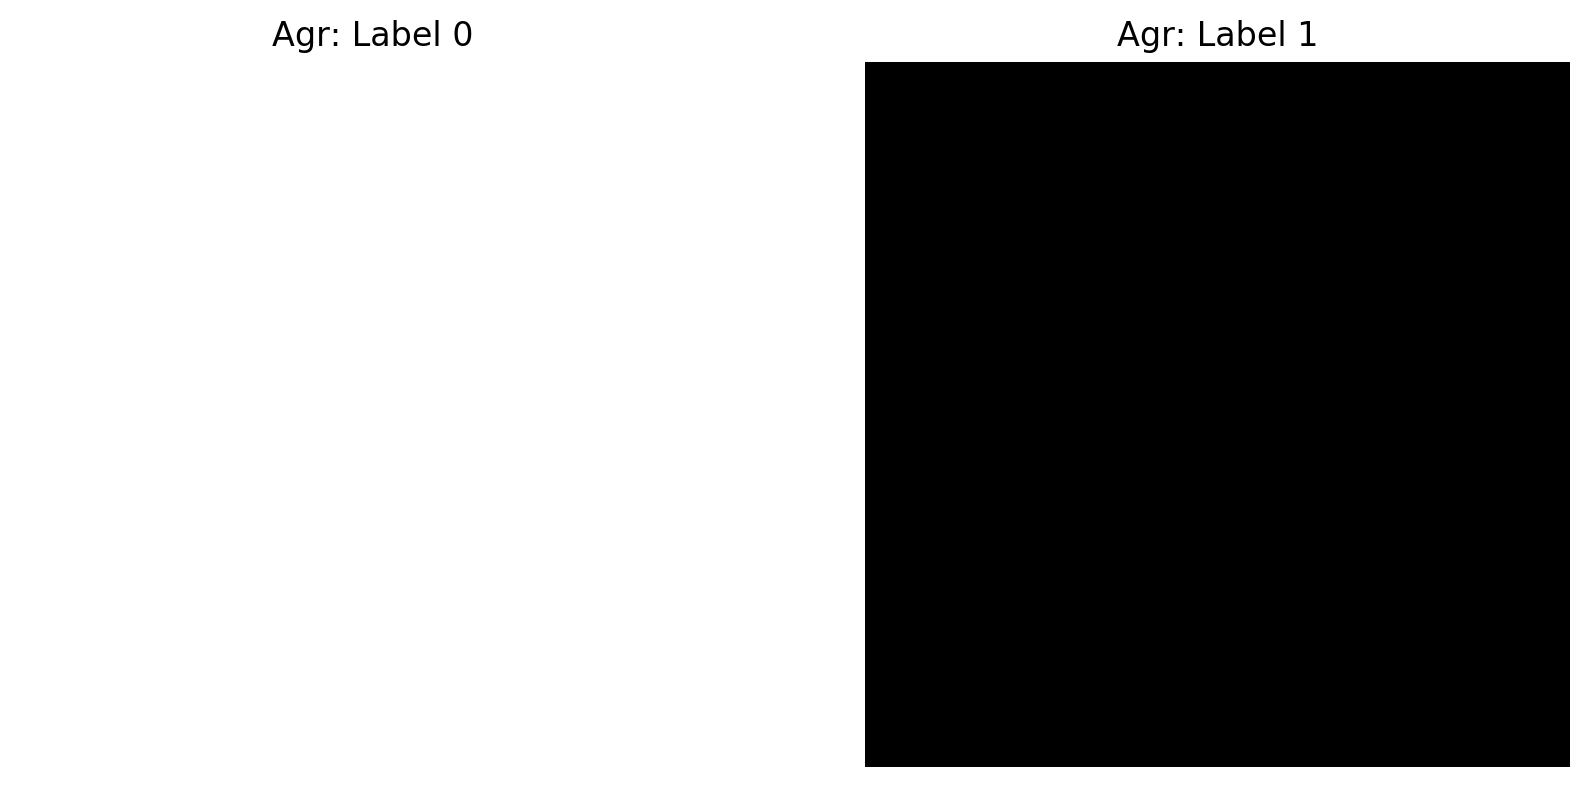

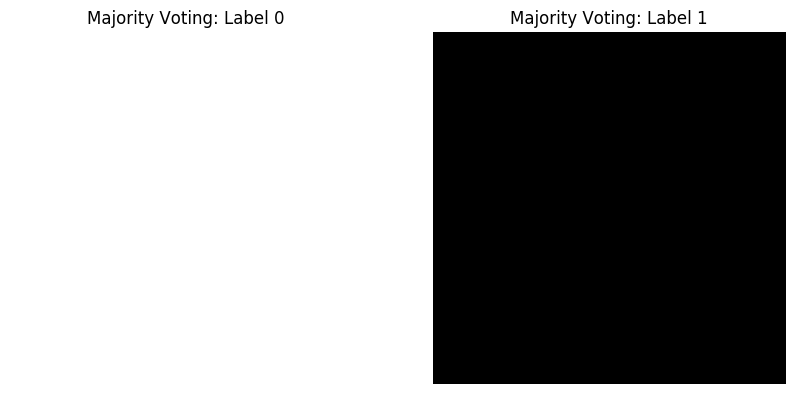

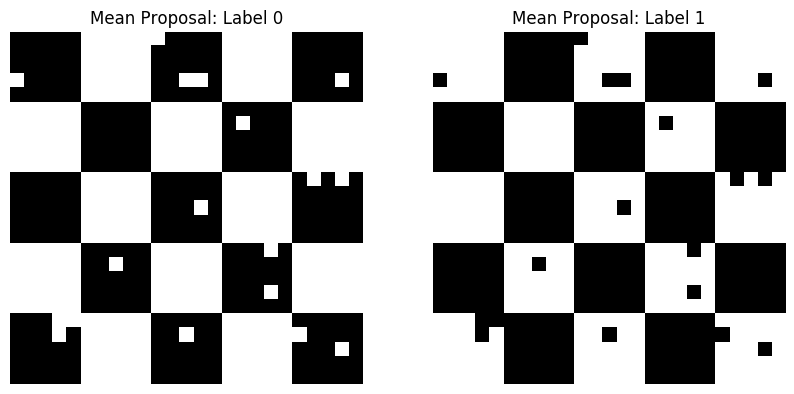

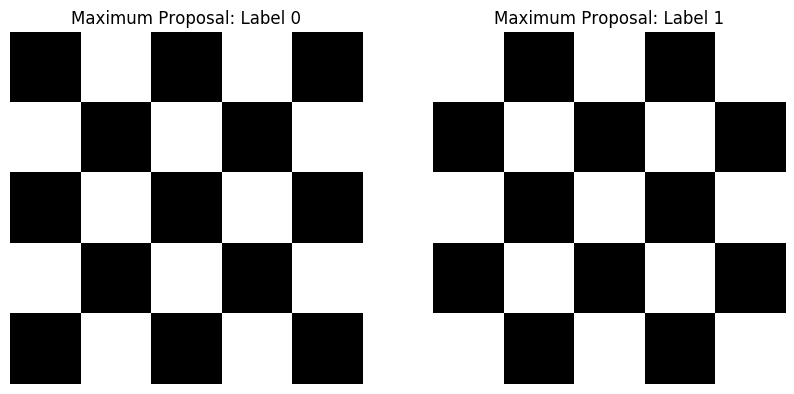

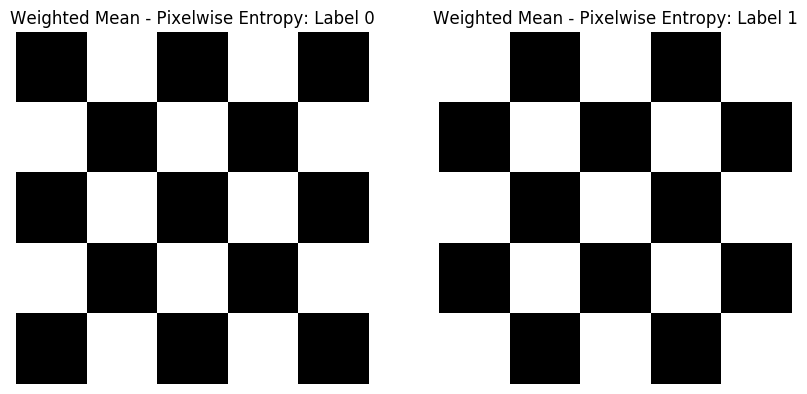

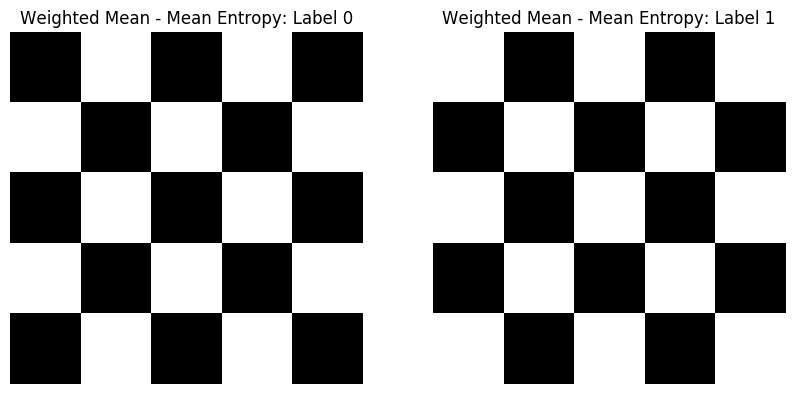

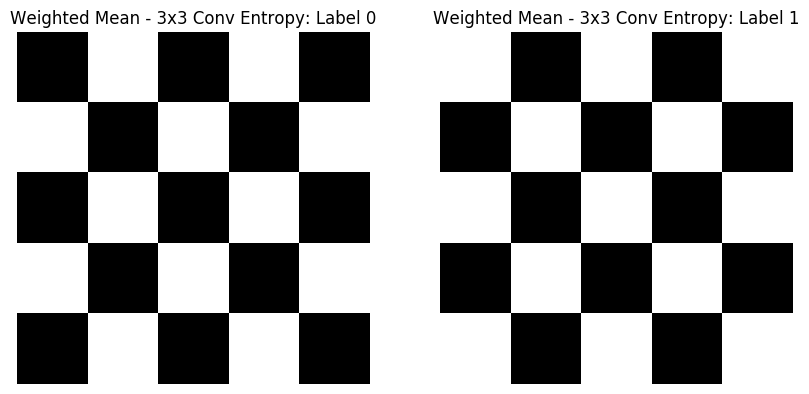

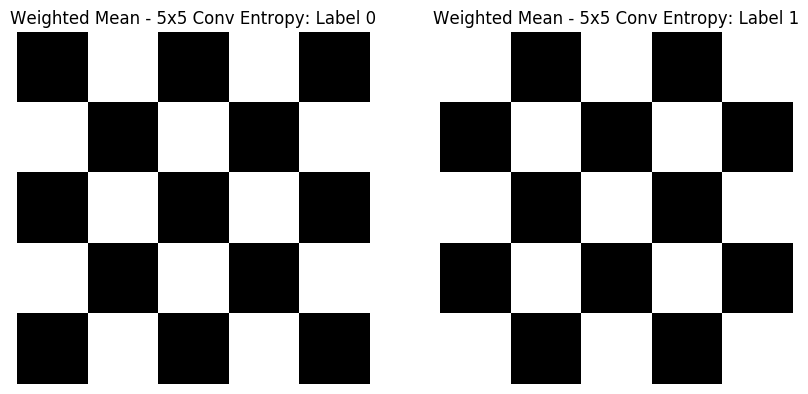

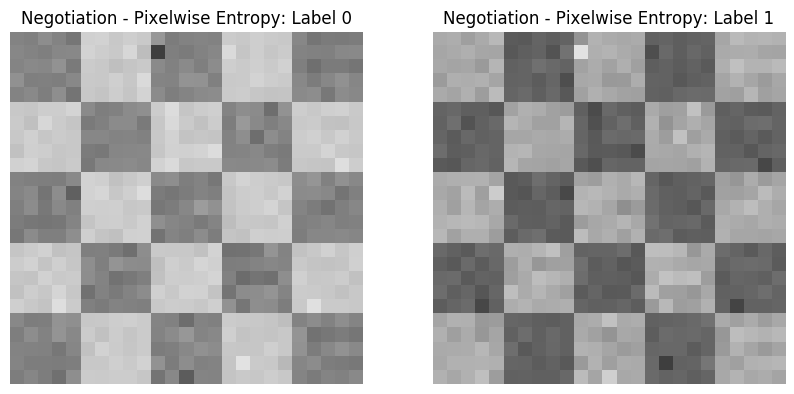

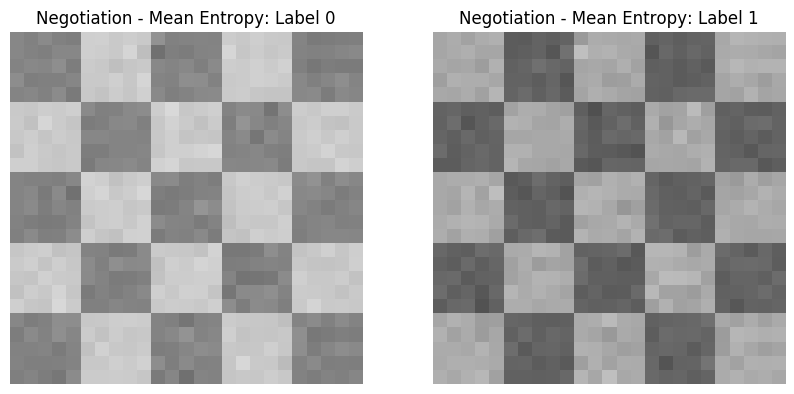

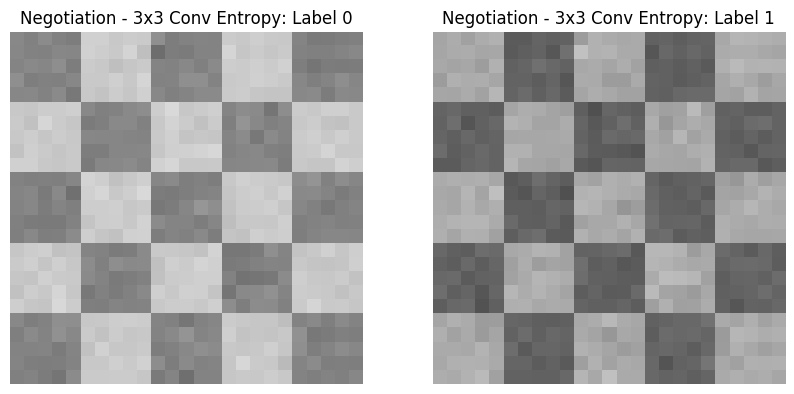

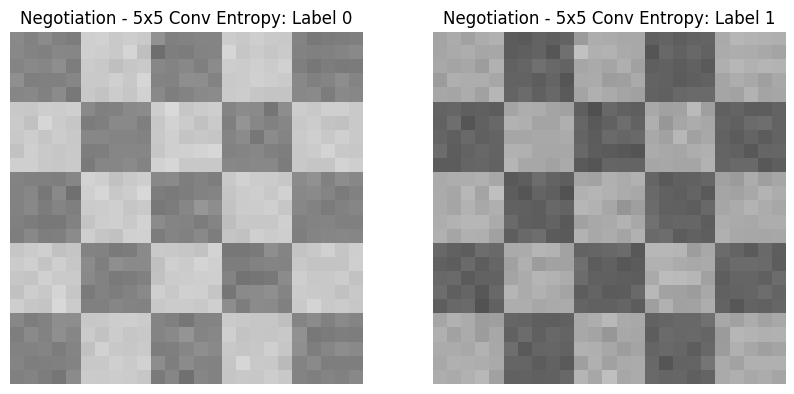

In [7]:
run_to_plot = 0
negtools.plot(ground_truth=gt, proposals=prediction_runs[run_to_plot], agreement=outputs[run_to_plot]['Majority Voting'])
for name, out in outputs[run_to_plot].items():
    if 'Neg' in name:
        negtools.plot(agreement=out['agr'], agreement_title=name, dpi=100)
    else:
        negtools.plot(agreement=out, agreement_title=name, dpi=100)

In [8]:
run_result

,Label 0_f1-score,Label 0_precision,Label 0_recall,Label 0_support,Label 1_f1-score,Label 1_precision,Label 1_recall,Label 1_support,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,non_consensus_px,method
0,0.018127,0.009146,1.0,3.0,0.000000,0.0,0.000000,325.0,0.009146,0.009063,0.004573,0.500000,328.0,0.000166,0.000084,0.009146,328.0,328.0,Majority Voting
1,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Maximum Proposal
2,0.250000,0.142857,1.0,3.0,0.971519,1.0,0.944615,325.0,0.945122,0.610759,0.571429,0.972308,328.0,0.964920,0.992160,0.945122,328.0,328.0,Mean Proposal
3,0.857143,0.750000,1.0,3.0,0.998459,1.0,0.996923,325.0,0.996951,0.927801,0.875000,0.998462,328.0,0.997167,0.997713,0.996951,328.0,328.0,Negotiation - 3x3 Conv Entropy
4,0.857143,0.750000,1.0,3.0,0.998459,1.0,0.996923,325.0,0.996951,0.927801,0.875000,0.998462,328.0,0.997167,0.997713,0.996951,328.0,328.0,Negotiation - 5x5 Conv Entropy
5,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Negotiation - Mean Entropy
6,0.600000,0.428571,1.0,3.0,0.993808,1.0,0.987692,325.0,0.987805,0.796904,0.714286,0.993846,328.0,0.990206,0.994774,0.987805,328.0,328.0,Negotiation - Pixelwise Entropy
7,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Weighted Mean - 3x3 Conv Entropy
8,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Weighted Mean - 5x5 Conv Entropy
9,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,1.000000,1.000000,1.000000,328.0,328.0,Weighted Mean - Mean Entropy


In [10]:
consensus_pred = np.stack([np.greater(prediction_runs[0][0], 0.5).astype(np.float32) for a in range(3)])

In [11]:
test_res, output_test = exp.run_experiment_on_list([prediction_runs[0], consensus_pred], [gt, gt], return_outputs=True)

Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 5
Proposals has full consensus, skipping...


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [13]:
test_res

,Label 0_f1-score,Label 0_precision,Label 0_recall,Label 0_support,Label 1_f1-score,Label 1_precision,Label 1_recall,Label 1_support,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,non_consensus_px,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,method
0,0.018127,0.009146,1.0,3.0,0.000000,0.0,0.000000,325.0,0.009146,0.009063,0.004573,0.500000,328.0,328.0,0.000166,0.000084,0.009146,328.0,Majority Voting
1,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,328.0,1.000000,1.000000,1.000000,328.0,Maximum Proposal
2,0.250000,0.142857,1.0,3.0,0.971519,1.0,0.944615,325.0,0.945122,0.610759,0.571429,0.972308,328.0,328.0,0.964920,0.992160,0.945122,328.0,Mean Proposal
3,0.857143,0.750000,1.0,3.0,0.998459,1.0,0.996923,325.0,0.996951,0.927801,0.875000,0.998462,328.0,328.0,0.997167,0.997713,0.996951,328.0,Negotiation - 3x3 Conv Entropy
4,0.857143,0.750000,1.0,3.0,0.998459,1.0,0.996923,325.0,0.996951,0.927801,0.875000,0.998462,328.0,328.0,0.997167,0.997713,0.996951,328.0,Negotiation - 5x5 Conv Entropy
5,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,328.0,1.000000,1.000000,1.000000,328.0,Negotiation - Mean Entropy
6,0.600000,0.428571,1.0,3.0,0.993808,1.0,0.987692,325.0,0.987805,0.796904,0.714286,0.993846,328.0,328.0,0.990206,0.994774,0.987805,328.0,Negotiation - Pixelwise Entropy
7,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,328.0,1.000000,1.000000,1.000000,328.0,Weighted Mean - 3x3 Conv Entropy
8,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,328.0,1.000000,1.000000,1.000000,328.0,Weighted Mean - 5x5 Conv Entropy
9,1.000000,1.000000,1.0,3.0,1.000000,1.0,1.000000,325.0,1.000000,1.000000,1.000000,1.000000,328.0,328.0,1.000000,1.000000,1.000000,328.0,Weighted Mean - Mean Entropy


In [64]:
N_LABELS = 3
C_STAR = 0
mu_star_list = [num/N_LABELS for num in [1+1e-6, 1.5] + list(range(N_LABELS)[2:])]
mu_list = [num/N_LABELS for num in [1, 1.1, 1.5] + list(range(N_LABELS-1)[3:])]

for std in [.01, .05, .1, .2]:
    for mu_star in mu_star_list:
        for mu in mu_list:
            if mu > mu_star:
                continue
            agmu, agsgm = agent_multiclass_expert(mu_star, mu, std, C_STAR, N_LABELS)
            #print(agmu)
            #print(agmu.sum(axis=-1))

In [65]:
N_LABELS = 3
C_STAR = 0
mu_star_list = [num/N_LABELS for num in [1+1e-6, 1.5] + list(range(N_LABELS)[2:])]
mu_list =[.4, .5, .6]
std_list = [.01, .05, .1, .2] 
gamma_list = [n/N_LABELS for n in range(N_LABELS) if n != 0]

for std in std_list:
    for mu_star in mu_star_list:
        for mu in mu_list:
            for gamma in gamma_list:
                agmu, agsgm = agent_multiclass_unbalanced(mu_star, mu, gamma, std, C_STAR, N_LABELS)
                

1 agente esperto per ogni label

In [4]:
template_name='chk'
template = templates[template_name]
N_LABELS = 4
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 30
mu_star_expert_list = [num/N_LABELS for num in [1+1e-6, 1.5] + list(range(N_LABELS)[2:])]
mu_expert_list = [num/N_LABELS for num in [1, 1.1, 1.5] + list(range(N_LABELS-1)[3:])]

log = pd.DataFrame()
for std in [.01, .05, .1, .2]:
    for mu_star in mu_star_expert_list:
        for mu in mu_expert_list:
            if mu > mu_star:
                continue
            prediction_runs = list()
            for i in range(SAMPLES):
                agents = [agent_multiclass_expert(mu_star, mu, std, c_star=l, n_labels=N_LABELS) for l in range(N_LABELS)]
                predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                prediction_runs.append(predictions)
            run_result, outputs = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES, return_outputs=True)
            run_result['mu_expert'] = mu
            run_result['mu_star_expert'] = mu_star
            run_result['std'] = std
            log = log.append(run_result, ignore_index=True)

Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 10
Sample 0 Consensus Reached at step, current step: 13
Sample 0 Consensus Reached at step, current step: 2
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 7
Sample 0 Consensus Reached at step, current step: 9
Sample 0 Consensus Reached at step, current step: 2
Sample 0 Consensus Reached at step, current step: 2
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 8
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 2
Sample 0 Consensus Reached at step, current step: 8
Sample 0 Consensus Reached at step, current step: 9
Sample 0 Consensus Reached at step, current step: 2
Sample 0 Consensus Reached at step, current step: 2
Sample 0 Consensus Reached at step, current step: 12
Sample 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps


/tf/src/Negotiation.py:36: RuntimeWarning: overflow encountered in multiply
  self.last_proposal = self.last_proposal + self.alpha*(agreement - self.last_proposal)
/tf/src/Negotiation.py:36: RuntimeWarning: invalid value encountered in subtract
  self.last_proposal = self.last_proposal + self.alpha*(agreement - self.last_proposal)


Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 10
Sample 0 Consensus Reached at step, current step: 16
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 7
Sample 0 Consensus Reached at step, current step: 9
Sample 0 Consensus Reached at step, current step: 12
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out af

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Consensus Reached at step, current step: 9
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 8
Sample 0 Consensus Reached at step, current step: 24
Sample 0 Consensus Reached at step, current step: 10
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 8
Sample 0 Consensus Reached at step, current step: 10
Sample 0 Consensus Reached at step, current step: 16
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 8
Sample 0 Consensus Reached at step, current step: 13
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Timed out after 1000 steps
Sample 0 Consensus Reached at step, current step: 13
Sample 0 Consensus Reached at step, current step: 8
Sample 0 Consensus Reached at step, current step: 

In [ ]:
# N Agenti sbilanciati per ogni label

In [11]:
template_name='chk'
template = templates[template_name]
N_LABELS = 4
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 30

mu_star_unb_list = [num/N_LABELS for num in [1+1e-6, 1.5] + list(range(N_LABELS)[2:])]
mu_unb_list =[.4, .5, .6]
gamma_unb_list = [n/N_LABELS for n in range(N_LABELS) if n != 0]

log = pd.DataFrame()
for std in [.01, .05, .1, .2]:
    for unb_agents in [1, 2, 3]: 
        for mu_star in mu_star_unb_list:
            for gamma in gamma_unb_list:
                for mu in mu_unb_list:
                    if mu > mu_star:
                        continue
                    prediction_runs = list()
                    agents = list()
                    for l in range(N_LABELS):
                        agents += [agent_multiclass_unbalanced(mu_star, mu, gamma, std, c_star=l, n_labels=N_LABELS)]*unb_agents
                        
                    for i in range(SAMPLES):
                        predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                        prediction_runs.append(predictions)
                        
                    run_result, outputs = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES, return_outputs=True)
                    run_result['mu_unbalanced'] = mu
                    run_result['mu_star_unbalanced'] = mu_star
                    run_result['gamma_unbalanced'] = gamma
                    run_result['unbalanced_agents'] = unb_agents
                    run_result['std'] = std
                    
                    log = log.append(run_result, ignore_index=True)

Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 11
Sample 0 Consensus Reached at step, current step: 13
Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 18
Sample 0 Consensus Reached at step, current step: 27
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 10
Sample 0 Consensus Reached at step, current step: 13
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 13
Sample 0 Consensus Reached at step, current step: 16
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 11
Sam

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Proposals has full consensus, skipping...
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Rea

KeyboardInterrupt: 

In [12]:
# 1 expert on C1 and 2/4/8 experts on C2

In [14]:
template_name='chk'
template = templates[template_name]
N_LABELS = 4
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 30

mu_star_unb_list = [num/N_LABELS for num in [1+1e-6, 1.5] + list(range(N_LABELS)[2:])]
mu_unb_list =[.4, .5, .6]
gamma_unb_list = [n/N_LABELS for n in range(N_LABELS) if n != 0]

mu_star_expert_list = [num/N_LABELS for num in [1+1e-6, 1.5] + list(range(N_LABELS)[2:])]
mu_expert_list = [num/N_LABELS for num in [1, 1.1, 1.5] + list(range(N_LABELS-1)[3:])]

log = pd.DataFrame()
for std in [.01, .05, .1, .2]:
    for unb_agents in [2, 4, 8]: 
        for mu_star_exp in mu_star_expert_list:
            for mu_exp in mu_expert_list:       
                for mu_star_unb in mu_star_unb_list:
                    for gamma in gamma_unb_list:
                        for mu_unb in mu_unb_list:
                            if mu_unb > mu_star_unb:
                                continue

                            prediction_runs = list()
                            
                            #####
                            expert = [agent_multiclass_expert(mu_star_exp, mu_exp, std, c_star=1, n_labels=N_LABELS)]
                            unbalanced = [agent_multiclass_unbalanced(mu_star_unb, mu_unb, gamma, std, c_star=2, n_labels=N_LABELS)]*unb_agents
                            agents = expert + unbalanced
                            
                            for i in range(SAMPLES):
                                predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                                prediction_runs.append(predictions)

                            run_result, outputs = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES, return_outputs=True)
                            run_result['mu_expert'] = mu_exp
                            run_result['mu_star_expert'] = mu_star_exp

                            run_result['mu_unbalanced'] = mu_unb
                            run_result['mu_star_unbalanced'] = mu_star_unb
                            run_result['gamma_unbalanced'] = gamma
                            run_result['unbalanced_agents'] = unb_agents
                            run_result['std'] = std

                            log = log.append(run_result, ignore_index=True)

Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 8
Sample 0 Consensus Reached at step, current step: 11
Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 4
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Consensus Reached at step, current step: 6
Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 3
Sample 0 Consensus Reached at step, current step: 5
Sample 0 Co

KeyboardInterrupt: 

In [15]:
print(templates['blobs'])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 0 0 0]
 [0 0 4 4 4 4 4 4 4 4 0 0 0 0 5 5 5 5 5 5 5 5 